In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
import matplotlib.colors as clr
from matplotlib.image import cm
import os
import sys

In [2]:
pepper_name = "peppers.jpg"
barn_name = "barn_mountains.jpg"
logo_name = "logo.jpg"

def plot_image_in_axe(name, axe, size):
    img = im.imread(name)
    axe.set_title('/'.join(name.split('/')[-2:]))
    
    axe.get_yaxis().set_visible(False)
    axe.get_xaxis().set_ticks([])
    
    kb_size = size/1024
    axe.set_xlabel(f"{img.shape[0]}x{img.shape[1]}\n{kb_size:.1f} KB")
    axe.imshow(img)
    

def plot_images(name):
    original_dir = os.getcwd() + "/imagens/bmp/" + name[:-3] + "bmp"
    low_dir = os.getcwd() + "/imagens/Low/" + name
    medium_dir = os.getcwd() + "/imagens/Medium/" + name
    high_dir = os.getcwd() + "/imagens/High/" + name
    
    original_bytes_size = os.stat(original_dir).st_size
    low_bytes_size = os.stat(low_dir).st_size
    medium_bytes_size = os.stat(medium_dir).st_size
    high_bytes_size = os.stat(high_dir).st_size
    
    
    fig, axes = plt.subplots(1, 4, figsize=(20,8))
    plot_image_in_axe(original_dir, axes[0], original_bytes_size)
    plot_image_in_axe(high_dir, axes[1], high_bytes_size)
    plot_image_in_axe(medium_dir, axes[2], medium_bytes_size)
    plot_image_in_axe(low_dir, axes[3], low_bytes_size)
    
    
    

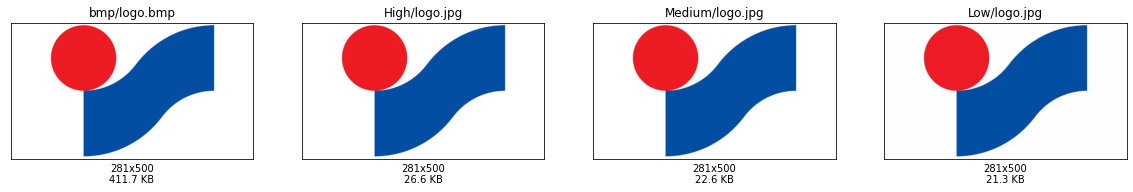

In [3]:
plot_images(logo_name)

In [4]:
"""
Recebe uma imagem e altera as suas dimensões (m,n) para (16*p, 16*q).
Isto é realizado através da cópia da ultima coluna/linha até atingir o valor multiplo de 16.
Devolva as dimensoes (m,n) originais e a imagem com as novas dimensoes (16*p, 16*q)
"""
def padding(img : np.array):
    img = img.copy()
    
    x = y = 0
    while img.shape[0]%16 != 0:
        img = np.concatenate((img, [img[-1]]), axis = 0)
        x+=1
    while img.shape[1]%16 != 0:
        img = np.concatenate((img, img[:,-1:]), axis = 1)
        y+=1
    return (x,y), img

"""
Recebe uma imagem e as dimensoes originais dela.
Enquanto as dimensoes da imagem forem diferentes das dimensoes de entrada, remove linhas/colunas 
até voltar ao tamanho original;
"""
def unpad(img : np.array, shape):
    img = img.copy()
    x,y = shape
    print(x,y)
    if x!=0 and y!=0:
        img = img[:-x,:-y,:]
    else:
        if x==0:
            if y!=0:
                img = img[:,:-y,:]
        else:
            img = img[:-x,:,:]
    return img

In [5]:
p_img = im.imread('imagens/Medium/logo.jpg')
shape, p_img2 = padding(p_img)
p_img3 = unpad(p_img2, shape)
np.all(np.equal(p_img, p_img3))

7 12


True

In [22]:
"""
Converte imagem no formato RGB para imagem no formato yCbCr;
"""
def rgb_to_ycbcr(img : np.array):
    img.copy()
    
    y_cb_cr_mat = np.array([ [0.299    , 0.587    , 0.114    ]
                            ,[-0.168736, -0.331264, 0.5      ]
                            ,[0.5      , -0.418688, -0.081312] ])
    
    y  = y_cb_cr_mat[0,0] * img[:,:,0] + y_cb_cr_mat[0,1] * img[:,:,1] + y_cb_cr_mat[0,2]*img[:,:,2]
    cb = y_cb_cr_mat[1,0] * img[:,:,0] + y_cb_cr_mat[1,1] * img[:,:,1] + y_cb_cr_mat[1,2]*img[:,:,2] + 128
    cr = y_cb_cr_mat[2,0] * img[:,:,0] + y_cb_cr_mat[2,1] * img[:,:,1] + y_cb_cr_mat[2,2]*img[:,:,2] + 128
    
    y_cb_cr = np.dstack((y, cb, cr))
    return y_cb_cr

"""
Converte imagem no formato yCbCr para imagem no formato RGB;
"""
def ycbcr_to_rgb(img : np.array):
    img = img.copy()
    
    y_cb_cr_mat_inv = np.linalg.inv(
                                np.array([ [0.299    , 0.587    , 0.114    ]
                                        ,  [-0.168736, -0.331264, 0.5      ]
                                        ,  [0.5      , -0.418688, -0.081312] ])
                                    )
    y = img[:,:,0]
    cb = img[:, :, 1] - 128
    cr = img[:, :, 2] - 128
    
    r = y_cb_cr_mat_inv[0,0] * y + y_cb_cr_mat_inv[0,1]*cb + y_cb_cr_mat_inv[0,2]*cr
    g = y_cb_cr_mat_inv[1,0] * y + y_cb_cr_mat_inv[1,1]*cb + y_cb_cr_mat_inv[1,2]*cr
    b = y_cb_cr_mat_inv[2,0] * y + y_cb_cr_mat_inv[2,1]*cb + y_cb_cr_mat_inv[2,2]*cr
    
    rgb = np.dstack((r,g,b))
    np.round(rgb)
    rgb[rgb > 255] = 255
    rgb[rgb < 0] = 0
    
    #return np.array(rgb, dtype = np.uint8)
    return rgb

In [23]:
def separate_rgb(img):
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    
    return r, g, b

def join_rgb(r, g, b):
    return np.dstack((r, g, b))

cm_gray = clr.LinearSegmentedColormap.from_list('gray', [(0,0,0), (1, 1, 1)], N = 256)
cm_red = clr.LinearSegmentedColormap.from_list('red', [(0,0,0), (1, 0, 0)], N = 256)
cm_green = clr.LinearSegmentedColormap.from_list('green', [(0,0,0), (0, 1, 0)], N = 256)
cm_blue = clr.LinearSegmentedColormap.from_list('blue', [(0,0,0), (0, 0, 1)], N = 256)


In [24]:
ycbcr_img = rgb_to_ycbcr(p_img)
rgb_img = ycbcr_to_rgb(ycbcr_img)
np.all(np.equal(p_img, rgb_img))

False

In [47]:
y, cb, cr = separate_rgb(ycbcr_img)

In [ ]:
"""

"""
def sub_sample(y: np.array, cb: np.array, cr: np.array, downsample_ratio: tuple[int]):
    y = y.copy()
    cb = cb.copy()
    cr = cr.copy()
    if downsample_ratio[-1] == 0:
        ratio = round(downsample_ratio[0]/downsample_ratio[1])
        cb = cb[::ratio,::ratio]
        cr = cr[::ratio,::ratio]
    else:
        v_ratio = round(downsample_ratio[0]/downsample_ratio[1])
        h_ratio = round(downsample_ratio[0]/downsample_ratio[2])
        cb = cb[:, ::v_ratio]
        cr = cr[:, ::v_ratio]
    return y,cb,cr

In [59]:
y,cb_d,cr_d = sub_sample(y,cb,cr, (4,2,0))

In [60]:
y.shape

(281, 500)

In [61]:
cb_d.shape

(141, 250)

In [62]:
cr_d.shape

(141, 250)